In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from lifelines import ExponentialFitter, WeibullFitter, CoxPHFitter, KaplanMeierFitter



In [2]:
%store -r df_cox
%store -r base_cox

# Ventana de Tiempo 2007Q4 a 2010Q4

In [3]:
%store -r df_cox
%store -r base_cox

In [4]:
base_cox

,Estado,Trim,GDP,TasaDesempleo,Personal_Income,SahmRule,Dummy,Fecha,recession_start,recession_end
0,Alabama,2007Q4,12.223257,4.133333,11.944742,0.516667,1,2007-10-01,True,False
1,Alabama,2008Q1,12.218838,5.000000,11.951368,1.216667,1,2008-01-01,False,False
2,Alabama,2008Q2,12.223525,5.200000,11.996815,1.133333,1,2008-04-01,False,False
3,Alabama,2008Q3,12.215361,6.400000,11.968071,2.146667,1,2008-07-01,False,False
4,Alabama,2008Q4,12.185424,7.000000,11.958987,2.503333,1,2008-10-01,False,False
...,...,...,...,...,...,...,...,...,...,...
645,Wyoming,2009Q4,10.545289,7.133333,10.096819,3.376667,1,2009-10-01,False,False
646,Wyoming,2010Q1,10.561624,8.133333,10.140325,2.620000,1,2010-01-01,False,False
647,Wyoming,2010Q2,10.575061,6.833333,10.163588,1.183333,1,2010-04-01,False,False
648,Wyoming,2010Q3,10.587316,6.200000,10.186939,0.076667,0,2010-07-01,False,True


In [5]:
fecha_corte = pd.Timestamp("2010-12-31")
records = []

for state, group in base_cox.groupby('Estado'):
    group = group.reset_index(drop=True)
    start_date = None
    
    for i, row in group.iterrows():
        # Detecta inicio de recesión
        if row['recession_start']:
            start_date = row['Fecha']
            
        # Detecta final de recesión
        elif row['recession_end'] and start_date is not None:
            end_date = row['Fecha']
            if end_date > fecha_corte:
                end_date = fecha_corte
                event = 0
            else:
                event = 1
            duration = (end_date.year - start_date.year) * 4 + (end_date.quarter - start_date.quarter) # en meses
            records.append([state, duration, event])
            start_date = None

    # Si el estado sigue en recesión al final del período → censurado
    if start_date is not None:
        end_date = min(group['Fecha'].max(), fecha_corte)
        duration = (end_date.year - start_date.year) * 4 + (end_date.quarter - start_date.quarter)
        records.append([state, duration, 0])

In [6]:
df_cox = pd.DataFrame(records, columns=['id', 'duration', 'event'])
covariables = base_cox.groupby('Estado')[['GDP', 'Personal_Income','TasaDesempleo']].mean().reset_index()
df_cox = df_cox.merge(covariables, left_on='id', right_on='Estado', how='left').drop(columns='Estado')
df_cox = df_cox.groupby('id', as_index=False).first()
df_cox

,id,duration,event,GDP,Personal_Income,TasaDesempleo
0,Alabama,11,1,12.198912,11.971114,8.328205
1,Alaska,12,0,10.869121,10.417288,7.358974
2,Arizona,12,1,12.573077,12.290408,8.241026
3,Arkansas,1,1,11.632072,11.433963,6.830769
4,California,12,1,14.584087,14.272265,9.984615
5,Colorado,11,0,12.540261,12.232355,7.046154
6,Connecticut,11,0,12.507552,12.276254,7.533333
7,Delaware,10,1,11.122248,10.509325,6.810256
8,Florida,11,1,13.671319,13.479717,8.894872
9,Georgia,11,1,13.068832,12.717952,8.589744


In [7]:
df_cox[df_cox['event']==1].count()

id                 45
duration           45
event              45
GDP                45
Personal_Income    45
TasaDesempleo      45
dtype: int64

In [8]:
%store df_cox

Stored 'df_cox' (DataFrame)


In [9]:
#Modelo parametrico

exp_model = ExponentialFitter()
exp_model.fit(df_cox['duration'], event_observed=df_cox['event'])
summary = exp_model.summary
exp_model.print_summary()


<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 50 total observations, 5 right-censored observations>
   number of observations = 50
number of events observed = 45
           log-likelihood = -149.99
               hypothesis = lambda_ != 0

---
         coef  se(coef)  coef lower 95%  coef upper 95%
lambda_ 10.31      1.54            7.30           13.32

         cmp to    z      p  -log2(p)
lambda_    0.00 6.71 <0.005     35.56
---
AIC = 301.99

In [10]:
# Weibull
weibull_model = WeibullFitter()
weibull_model.fit(df_cox['duration'], event_observed=df_cox['event'])
summary = weibull_model.summary
weibull_model.print_summary()

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 50 total observations, 5 right-censored observations>
   number of observations = 50
number of events observed = 45
           log-likelihood = -126.60
               hypothesis = lambda_ != 1, rho_ != 1

---
         coef  se(coef)  coef lower 95%  coef upper 95%
lambda_ 10.38      0.48            9.44           11.32
rho_     3.23      0.46            2.33            4.14

         cmp to     z      p  -log2(p)
lambda_    1.00 19.57 <0.005    280.76
rho_       1.00  4.83 <0.005     19.49
---
AIC = 257.20

In [11]:
cox = CoxPHFitter()
cox.fit(df_cox, duration_col='duration', event_col='event', formula="GDP")
summary = cox.summary
cox.print_summary()

<lifelines.CoxPHFitter: fitted with 50 total observations, 5 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 50
number of events observed = 45
   partial log-likelihood = -141.17
         time fit was run = 2025-11-27 20:34:47 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
GDP       -0.10      0.91      0.14           -0.38            0.19                0.68                1.21

           cmp to     z    p  -log2(p)
covariate                             
GDP          0.00 -0.66 0.51      0.97
---
Concordance = 0.57
Partial AIC = 284.34
log-likelihood ratio test = 0.44 on 1 df
-log2(p) of ll-ratio test = 0.97

In [12]:
cox = CoxPHFitter()
cox.fit(df_cox, duration_col='duration', event_col='event', formula="GDP+Personal_Income")
summary = cox.summary
cox.print_summary()

<lifelines.CoxPHFitter: fitted with 50 total observations, 5 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 50
number of events observed = 45
   partial log-likelihood = -139.72
         time fit was run = 2025-11-27 20:34:48 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
GDP             -3.44      0.03      2.04           -7.45            0.56                0.00                1.76
Personal_Income  3.35     28.56      2.05           -0.67            7.37                0.51             1593.24

                 cmp to     z    p  -log2(p)
covariate                                   
GDP                0.00 -1.68 0.09      3.44
Personal_Income    0.00  1.63 0.10      3.29
---
Concordance = 0.62
Partial AIC = 283.44
log-likelihood ratio test = 3.34 on 2 df
-log2(p) of ll-ratio test = 2.41

In [13]:
cox = CoxPHFitter()
cox.fit(df_cox, duration_col='duration', event_col='event', formula="GDP+Personal_Income+TasaDesempleo")
summary = cox.summary
cox.print_summary()

<lifelines.CoxPHFitter: fitted with 50 total observations, 5 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 50
number of events observed = 45
   partial log-likelihood = -135.35
         time fit was run = 2025-11-27 20:34:48 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
GDP             -3.21      0.04      2.00           -7.14            0.72                0.00                2.06
Personal_Income  3.34     28.22      2.01           -0.60            7.28                0.55             1448.52
TasaDesempleo   -0.38      0.68      0.14           -0.65           -0.11                0.52                0.89

                 cmp to     z      p  -log2(p)
covariate                                     
GDP                0.00 -1.60   0.11      3.19
Personal_Income    0.00  1.66   0.10      3.37
TasaDesempleo      0.00 -2.81 <0.005      7.65
---
Concordance = 0.71
Partial AIC = 276.70
log-likelihood ratio test = 12.07 on 3 df
-log2(p) of ll-ratio test = 7.13

In [14]:
cox = CoxPHFitter()
cox.fit(df_cox, duration_col='duration', event_col='event', formula="GDP+TasaDesempleo")
summary = cox.summary
cox.print_summary()

<lifelines.CoxPHFitter: fitted with 50 total observations, 5 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 50
number of events observed = 45
   partial log-likelihood = -136.84
         time fit was run = 2025-11-27 20:34:48 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
GDP            0.13      1.14      0.17           -0.20            0.46                0.82                1.59
TasaDesempleo -0.38      0.68      0.14           -0.64           -0.11                0.53                0.89

               cmp to     z    p  -log2(p)
covariate                                 
GDP              0.00  0.77 0.44      1.19
TasaDesempleo    0.00 -2.80 0.01      7.62
---
Concordance = 0.69
Partial AIC = 277.67
log-likelihood ratio test = 9.10 on 2 df
-log2(p) of ll-ratio test = 6.57

#### Analisis del GDP

In [15]:
# Ordenar estados por GDP
df_sorted = df_cox.sort_values(by='GDP')

# 25 estados con menor GDP
df_low_gdp = df_sorted.iloc[:25].copy()

# 25 estados con mayor GDP
df_high_gdp = df_sorted.iloc[25:].copy()

df_high_gdp 

,id,duration,event,GDP,Personal_Income,TasaDesempleo
0,Alabama,11,1,12.198912,11.971114,8.328205
17,Louisiana,10,0,12.401599,12.036840,6.058974
6,Connecticut,11,0,12.507552,12.276254,7.533333
5,Colorado,11,0,12.540261,12.232355,7.046154
48,Wisconsin,1,1,12.557367,12.295293,7.143590
2,Arizona,12,1,12.573077,12.290408,8.241026
41,Tennessee,10,1,12.589257,12.303097,8.587179
24,Missouri,11,1,12.592539,12.295402,7.979487
22,Minnesota,11,1,12.627655,12.311342,6.658974
13,Indiana,10,1,12.660891,12.326050,8.374359


In [16]:
cox_low = CoxPHFitter()
cox_low.fit(df_low_gdp, duration_col='duration', event_col='event', formula="GDP")
cox_low.print_summary()

<lifelines.CoxPHFitter: fitted with 25 total observations, 2 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 25
number of events observed = 23
   partial log-likelihood = -57.31
         time fit was run = 2025-11-27 20:34:48 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
GDP       -0.04      0.96      0.39           -0.80            0.72                0.45                2.05

           cmp to     z    p  -log2(p)
covariate                             
GDP          0.00 -0.10 0.92      0.12
---
Concordance = 0.50
Partial AIC = 116.61
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.12

In [17]:
cox_high = CoxPHFitter()
cox_high.fit(df_high_gdp, duration_col='duration', event_col='event', formula="GDP")
cox_high.print_summary()

<lifelines.CoxPHFitter: fitted with 25 total observations, 3 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 25
number of events observed = 22
   partial log-likelihood = -52.98
         time fit was run = 2025-11-27 20:34:48 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
GDP        0.10      1.10      0.30           -0.50            0.69                0.61                1.99

           cmp to    z    p  -log2(p)
covariate                            
GDP          0.00 0.32 0.75      0.42
---
Concordance = 0.60
Partial AIC = 107.97
log-likelihood ratio test = 0.10 on 1 df
-log2(p) of ll-ratio test = 0.41

In [24]:
%store -r base_cox_kaplan

In [25]:
base_cox_kaplan
base_cox_kaplan = base_cox_kaplan[base_cox_kaplan['Fecha']>='2007-09-01']
base_cox_kaplan = base_cox_kaplan[base_cox_kaplan['Fecha']<='2010-12-31']
base_cox_kaplan

,Estado,Fecha,TasaDesempleo,Trim,GDP,Personal_Income,Abr,U_3m,U_min12,SahmRule,Dummy
213,Alabama,2007-10-01,3.9,2007Q4,203466.6,154005.2,AL,4.10,3.57,0.53,1
214,Alabama,2007-10-01,4.1,2007Q4,203466.6,154005.2,AL,4.03,3.57,0.46,0
215,Alabama,2007-10-01,4.4,2007Q4,203466.6,154005.2,AL,4.13,3.57,0.56,1
216,Alabama,2008-01-01,5.1,2008Q1,202569.5,155029.1,AL,4.53,3.57,0.96,1
217,Alabama,2008-01-01,5.0,2008Q1,202569.5,155029.1,AL,4.83,3.57,1.26,1
...,...,...,...,...,...,...,...,...,...,...,...
21219,Wyoming,2010-07-01,6.2,2010Q3,39629.0,26554.1,WY,6.40,6.37,0.03,0
21220,Wyoming,2010-07-01,6.0,2010Q3,39629.0,26554.1,WY,6.20,6.20,0.00,0
21221,Wyoming,2010-10-01,6.0,2010Q4,39144.3,26901.8,WY,6.07,6.07,0.00,0
21222,Wyoming,2010-10-01,6.5,2010Q4,39144.3,26901.8,WY,6.17,6.07,0.10,0


In [26]:
base_cox_kaplan = pd.DataFrame(records, columns=['Estado', 'duration', 'event'])
duracion_promedio = base_cox_kaplan.groupby('Estado')['duration'].max().sort_values()
estados_menor = duracion_promedio.head(5).index.tolist()
estados_mayor = duracion_promedio.tail(5).index.tolist()
estados_seleccionados = estados_menor + estados_mayor
base_cox_kaplan = base_cox_kaplan[base_cox_kaplan['Estado'].isin(estados_seleccionados)].copy()
base_cox_kaplan['grupo'] = np.where(base_cox_kaplan['Estado'].isin(estados_mayor), 'Mayor duración', 'Menor duración')
base_cox_kaplan


,Estado,duration,event,grupo
0,Alabama,11,1,Mayor duración
1,Alaska,12,0,Mayor duración
2,Arizona,12,1,Mayor duración
5,California,12,1,Mayor duración
16,Kansas,7,1,Menor duración
28,Nebraska,1,1,Menor duración
29,Nebraska,1,1,Menor duración
30,Nebraska,6,1,Menor duración
31,Nevada,12,0,Mayor duración
37,North Dakota,3,1,Menor duración


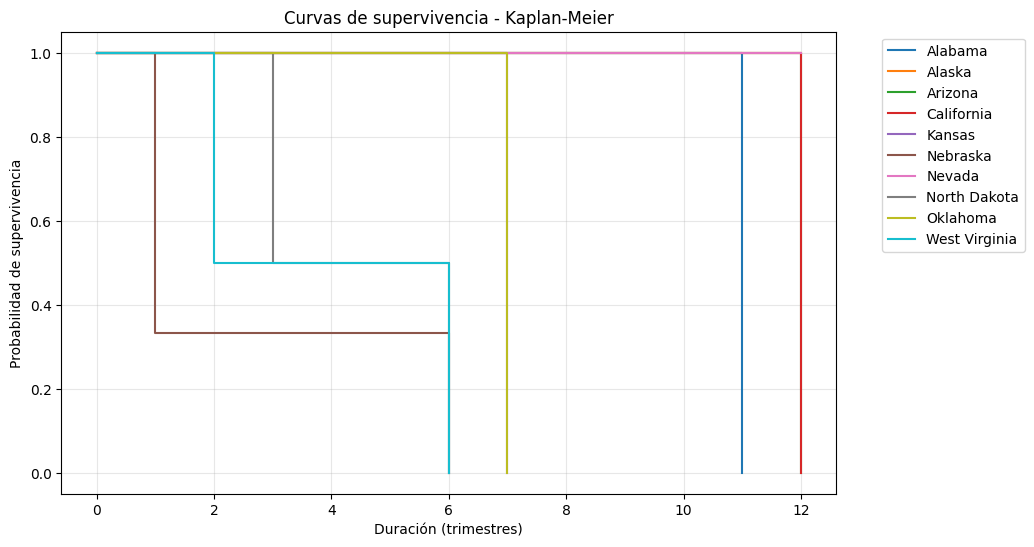

In [27]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
for estado, grupo in base_cox_kaplan.groupby('Estado'):
    kmf.fit(grupo['duration'], event_observed=grupo['event'], label=estado)
    kmf.plot_survival_function(ci_show=False)

plt.title('Curvas de supervivencia - Kaplan-Meier')
plt.xlabel('Duración (trimestres)')
plt.ylabel('Probabilidad de supervivencia')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()


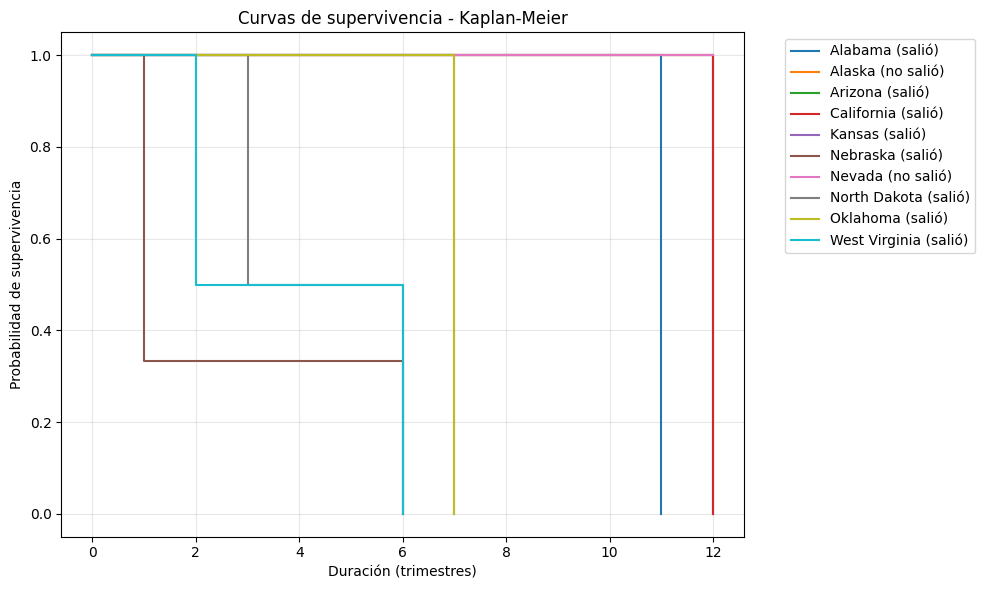

In [28]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Determinar para cada estado si salió o no
estado_evento = base_cox_kaplan.groupby('Estado')['event'].max().to_dict()

for estado, grupo in base_cox_kaplan.groupby('Estado'):
    
    # Crear etiqueta según el evento
    if estado_evento[estado] == 1:
        etiqueta = f"{estado} (salió)"
    else:
        etiqueta = f"{estado} (no salió)"

    kmf.fit(grupo['duration'], event_observed=grupo['event'], label=etiqueta)
    kmf.plot_survival_function(ci_show=False)

plt.title('Curvas de supervivencia - Kaplan-Meier')
plt.xlabel('Duración (trimestres)')
plt.ylabel('Probabilidad de supervivencia')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


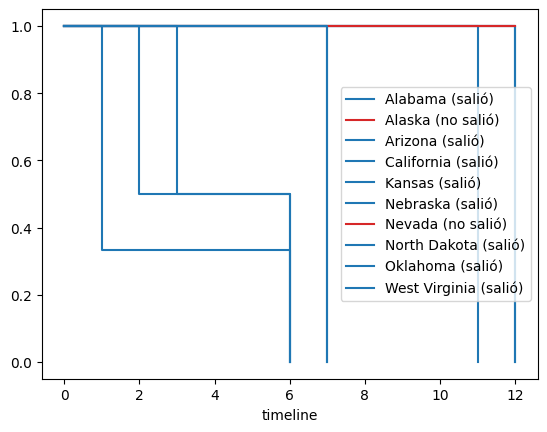

In [23]:
for estado, grupo in base_cox_kaplan.groupby('Estado'):
    kmf.fit(grupo['duration'], grupo['event'])

    color = 'tab:blue' if grupo['event'].max() == 1 else 'tab:red'
    label = f"{estado} ({'salió' if grupo['event'].max() else 'no salió'})"

    kmf.plot_survival_function(ci_show=False, color=color, label=label)
